In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr

<IPython.core.display.Javascript object>


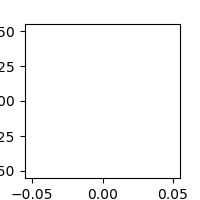

In [265]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

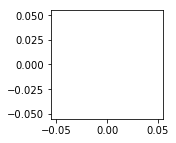

In [280]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [11]:
dfmg = pd.read_csv("dfmg_glDist.csv")
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])

In [12]:
import plot_stations as pltStn
import importlib
importlib.reload(pltStn)

import plot_bathy as pltBathy
import importlib
importlib.reload(pltBathy)

import find_depth_averages_v2 as averageProfile
import plot_var_contours_with_distance as plt2dDepthVsDist

import plot_station_bot_sal as pbs

import plot_topView_contourf as topView
importlib.reload(topView)

import plot_monthly_count as monthCount
importlib.reload(monthCount)

import plot_theta_sal
importlib.reload(plot_theta_sal)

import plot_year_vs_salAverages as pltSalYearAvg
importlib.reload(pltSalYearAvg)

import plot_profiles_vs_dist as profDist

In [13]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 80)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8)
Prydz = (box9 | box10)
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea

dfmg['mab'] = abs(dfmg['ECHODEPTH'] - dfmg['DEPTH'])
lt60 = abs(dfmg['mab']) < 60
lt100 = abs(dfmg['mab']) < 100
lt200 = abs(dfmg['mab']) < 200

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25
gline_le_75km = dfmg['DIST_GLINE'] <= 75

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deep_mask = dfmg['deep_flag'] == 1.0
deep_mask = deep_mask + (dfmg['ECHODEPTH'] < 100)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [14]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [15]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

## $\theta$ - S profiles - All Data

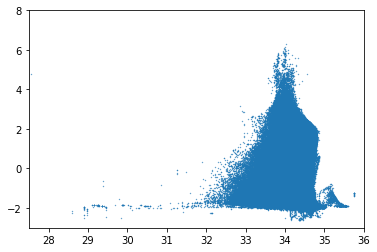

In [8]:
all_thetas = dfmg.loc[:, 'CTEMP']
all_sals = dfmg.loc[:, 'PSAL_ADJUSTED']
plt.scatter(all_sals, all_thetas, s=0.1)
plt.xlim(27.5, 36)
plt.ylim(-3, 8)
plt.show()

## $\theta$ - S profiles - Weddell Sea

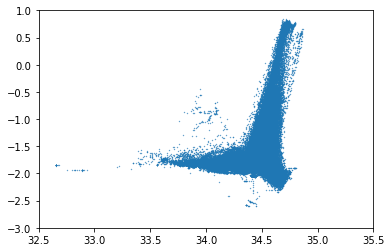

In [63]:
thetas = dfmg.loc[Weddell & mask_theta_sal_not_nan, 'CTEMP']
sals = dfmg.loc[Weddell & mask_theta_sal_not_nan, 'PSAL_ADJUSTED']

plt.scatter(sals, thetas, s=0.1)
plt.xlim(32.5, 35.5)
plt.ylim(-3, 1)
plt.show()

#### Year-wise $\theta$-S plots

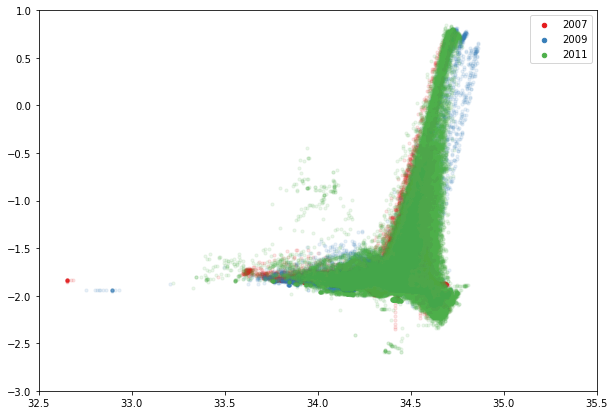

In [20]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Weddell, years=[2007, 2009, 2011], alpha=0.1, s=10, wd=10, ht=7)

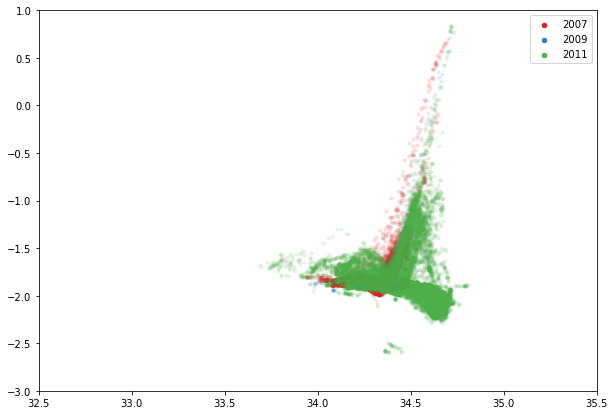

In [17]:
thetas = dfmg.loc[Weddell & gline_le_150km & mask_theta_sal_not_nan, 'CTEMP']
sals = dfmg.loc[Weddell & gline_le_150km & mask_theta_sal_not_nan, 'PSAL_ADJUSTED']

plot_theta_sal.plot_theta_s_yearly(dfmg, Weddell&gline_le_150km, years=[2007, 2009, 2011], alpha=0.1, wd=10, ht=7, 
                                   s=10)

## $\theta$ - S profiles - Ross Sea

In [498]:
importlib.reload(plot_theta_sal)

<module 'plot_theta_sal' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_theta_sal.py'>

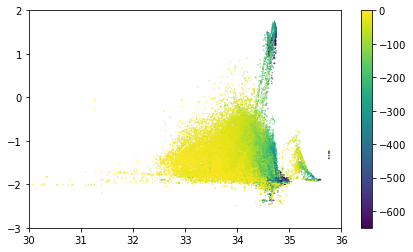

In [499]:
plot_theta_sal.plot_theta_s(dfmg, Ross, thetamax=2, alpha=1)

In [503]:
12//5

2

In [485]:
mask = dfmg[Ross].groupby('PROFILE_NUMBER').tail(1).index
dfmg[Ross].loc[mask].groupby(pd.cut(dfmg[Ross].loc[mask].DEPTH, depth_buckets)).JULD.count()

DEPTH
(-3000, -1000]       1
(-1000, -950]        2
(-950, -900]         2
(-900, -850]         8
(-850, -800]        23
(-800, -750]        46
(-750, -700]        68
(-700, -650]        94
(-650, -600]       126
(-600, -550]       263
(-550, -500]       521
(-500, -450]       769
(-450, -400]       907
(-400, -350]      1133
(-350, -300]      1318
(-300, -250]      1368
(-250, -200]      1368
(-200, -150]      1440
(-150, -100]      1131
(-100, -50]        630
(-50, 0]           110
Name: JULD, dtype: int64

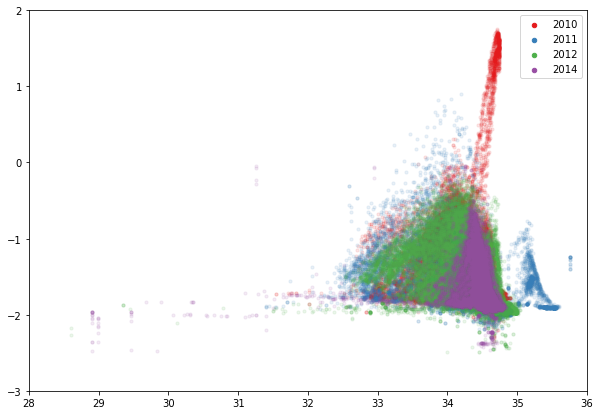

In [29]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross, salmin=28, salmax=36, tempmax=2, 
                                   years=[2010, 2011, 2012, 2014], alpha=0.1, wd=10, ht=7, 
                                   s=10)

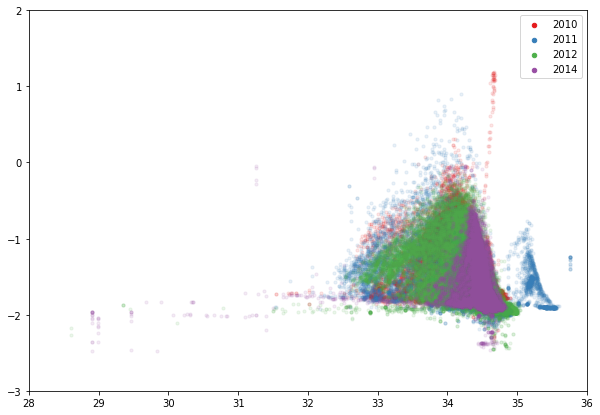

In [28]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&gline_le_150km, salmin=28, salmax=36, tempmax=2, 
                                   years=[2010, 2011, 2012, 2014], alpha=0.1, wd=10, ht=7, 
                                   s=10)

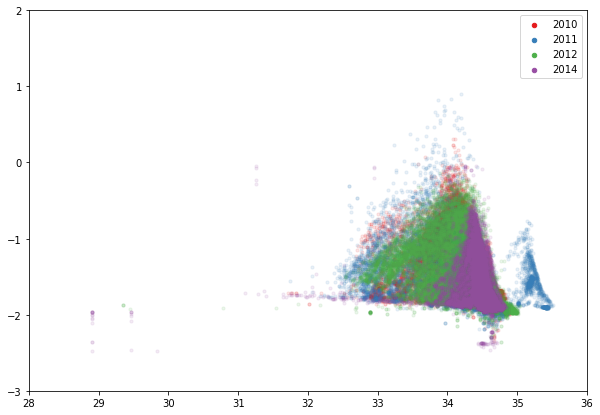

In [30]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&gline_le_50km, salmin=28, salmax=36, tempmax=2, 
                                   years=[2010, 2011, 2012, 2014], alpha=0.1, wd=10, ht=7, 
                                   s=10)

In [31]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PROFILE_NUMBER', 'PSAL_ADJUSTED',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'DEPTH',
       'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP', 'DENSITY_GRADIENT',
       'ECHODEPTH', 'mab', 'deep_flag', 'DIST_GLINE'],
      dtype='object')

In [44]:
import find_depth_averages_v2
importlib.reload(find_depth_averages_v2)

<module 'find_depth_averages_v2' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py'>

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


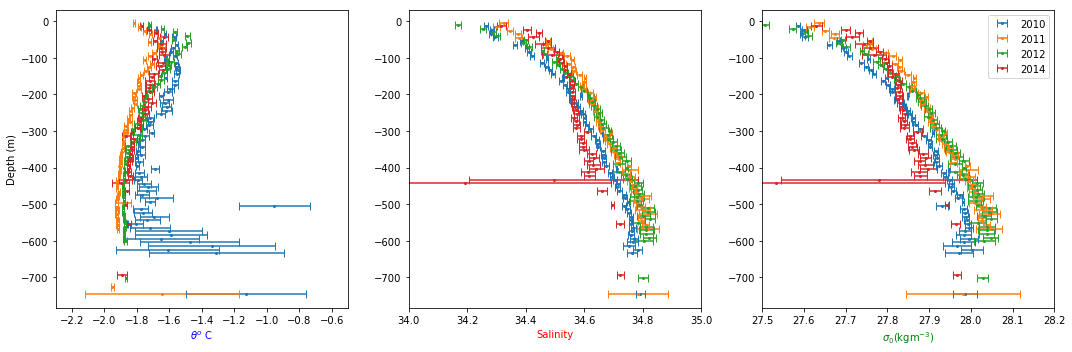

In [111]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Ross, 
                                                    years=[2010, 2011, 2012, 2014], sigmin=27.5, 
                                                    sigmax=28.2, salmin=34, salmax=35, wd=15)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


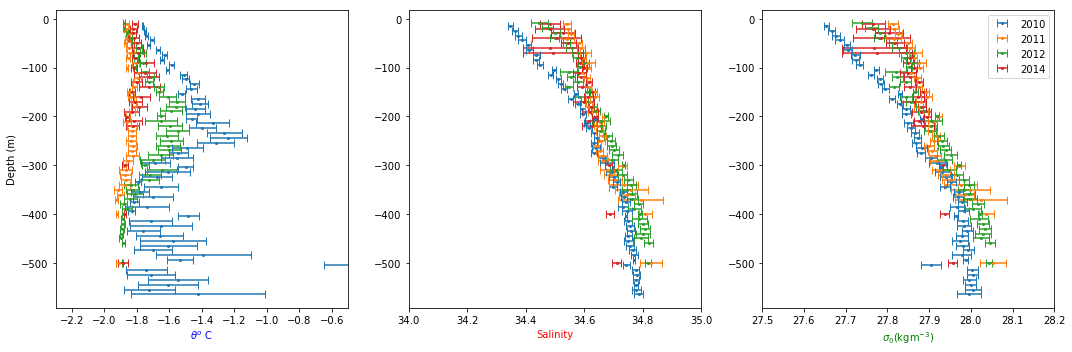

In [112]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Ross &~(gline_le_100km), 
                                                    years=[2010, 2011, 2012, 2014], sigmin=27.5, 
                                                    sigmax=28.2, salmin=34, salmax=35, wd=15)

<IPython.core.display.Javascript object>


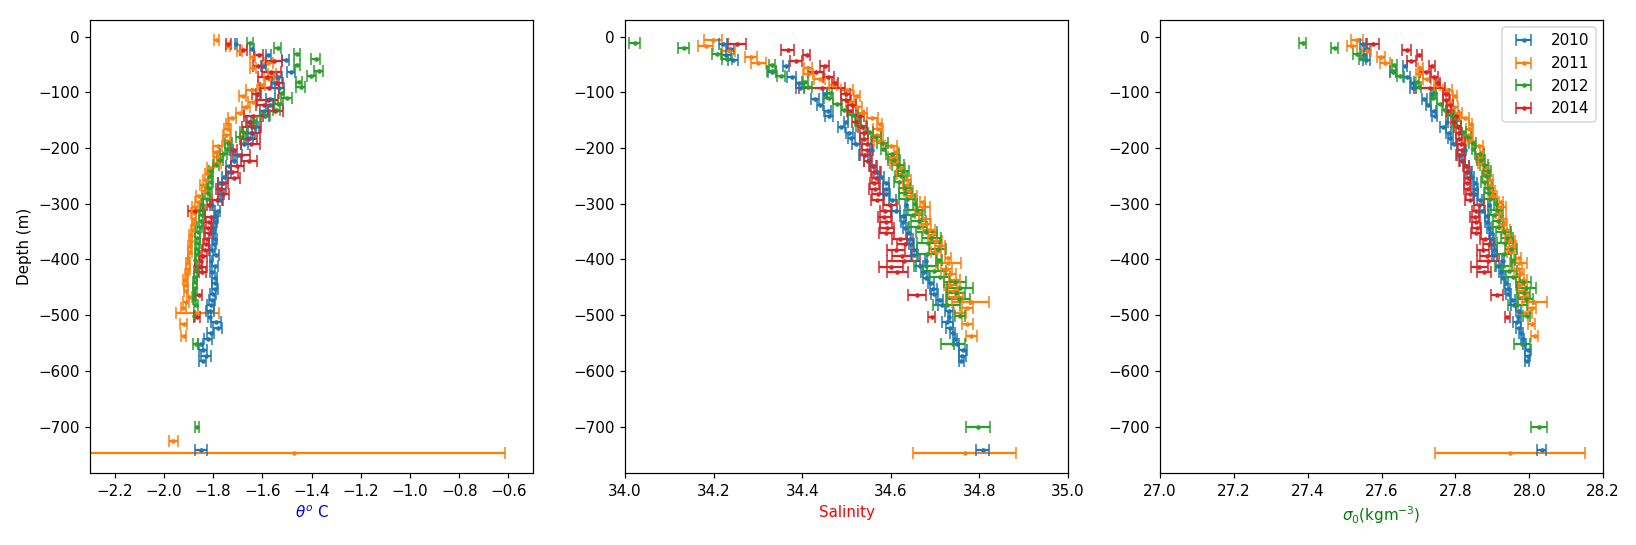

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


In [121]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Ross & (gline_le_50km), 
                                                    years=[2010, 2011, 2012, 2014], sigmin=27., 
                                                    sigmax=28.2, salmin=34, salmax=35, wd=15)

## Bottom Salinities

#### Ross Sea, Bottom Salinity

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


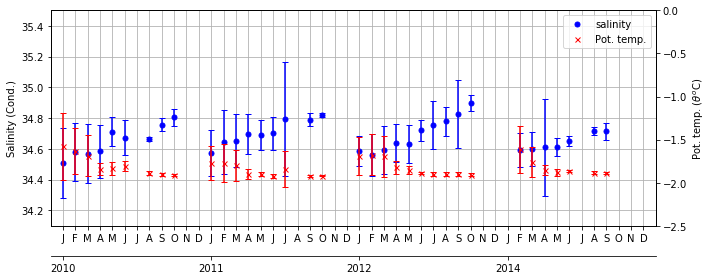

In [817]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Ross&gline_le_75km&deep_mask, 
                                              years=[2010, 2011, 2012, 2014], markersize=5, 
                                              save=True, savename="./Images/RossBotSal_GLle75km.png", salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


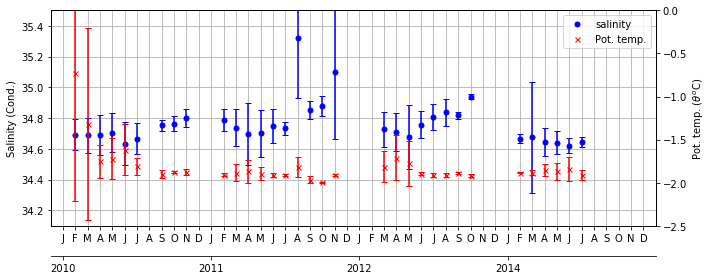

In [818]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Ross&~gline_le_75km&deep_mask, 
                                              years=[2010, 2011, 2012, 2014], markersize=5, save=True, 
                                            savename="./Images/RossBotSal_Xclude_GLle75km.png", salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

#### Weddell Sea, Bottom Salinity

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


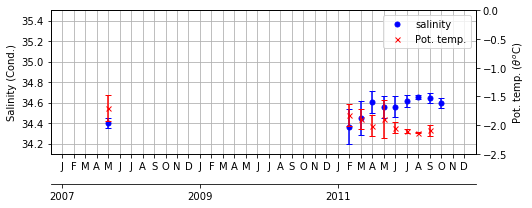

In [819]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Weddell&gline_le_75km&deep_mask, 
                                              years=[2007, 2009, 2011], markersize=5, save=True, 
                                              savename="./Images/WeddellBotSal_GLle75km.png", wd=10.*3./4., 
                                                    ht=4.*3./4., salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


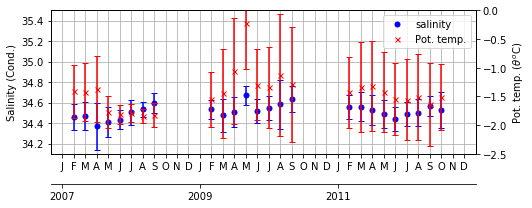

In [820]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Weddell&~gline_le_75km, 
                                              years=[2007, 2009, 2011], markersize=5, save=True, 
                                              savename="./Images/WeddellBotSal_Xclude_GLle75km.png", wd=10.*3./4., 
                                                    ht=4.*3./4., salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

#### Prydz Bay bottom salinity

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


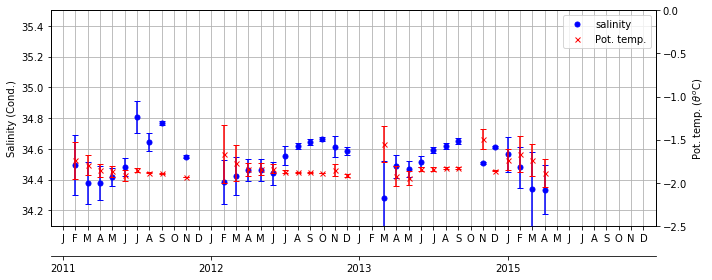

In [821]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Prydz&gline_le_75km, 
                                              years=[2011, 2012, 2013, 2015], markersize=5, wd=10, ht=4, save=True,
                                             savename="./Images/PrydzBotSal_GLle75km.png", salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


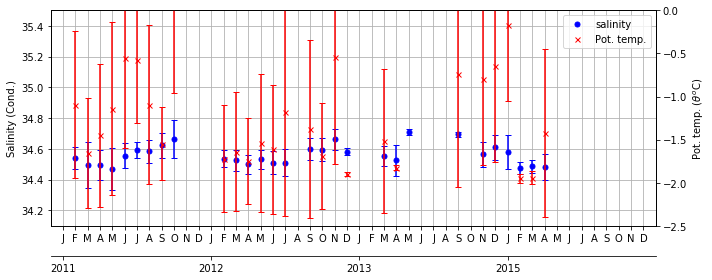

In [822]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Prydz&deep_mask&~gline_le_75km, 
                                              years=[2011, 2012, 2013, 2015], markersize=5, wd=10,ht=4, save=True,
                                             savename="./Images/PrydzBotSal_Xclude_GLle75km.png", salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


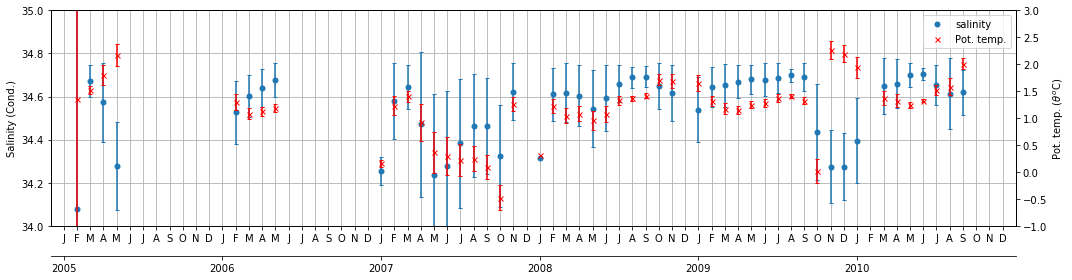

In [550]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, EBS+WBS, 
                                              years=[2005, 2006, 2007, 2008, 2009, 2010], markersize=5, wd=15, 
                                                    save=True,
                                             savename="./Images/BSbotSal.png", salmin=34.,
                                                   salmax=35., thetamin=-1., thetamax=3.)

## Surface Salinities

In [917]:
importlib.reload(pltSalYearAvg)

<module 'plot_year_vs_salAverages' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_year_vs_salAverages.py'>

11.958699187786596 1027.99528863 34.8972988987 1027.07837163 33.7739340784
11.958699187786596 1027.98133165 34.8754811034 1027.00715616 33.6822657235
11.958699187786596 1027.9934967 34.896014695 1026.85145186 33.5150240375
11.958699187786596 1027.99165522 34.863617132 1027.2590942 34.0009622107


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


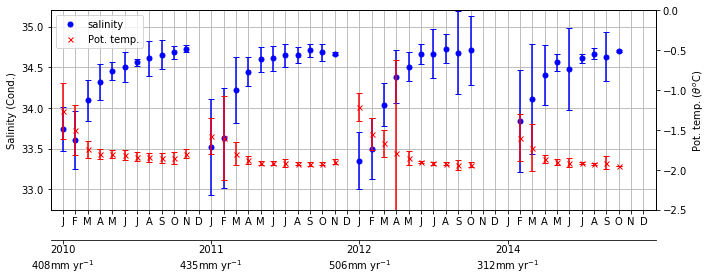

In [918]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Ross&gline_le_75km, 
                                              years=[2010, 2011, 2012, 2014], markersize=5, save=True, 
                                                    savename="./Images/RossSurfSalGLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

In [909]:
dfmg.groupby("PROFILE_NUMBER").head(1).DEPTH.mean() * 2.

-13.770256118783585

In [910]:
dfmg.groupby("PROFILE_NUMBER").head(1).DEPTH.median() * 2.

-11.880608395179296

11.894863326238244 1027.95674379 34.8495672311 1027.26404434 34.0089776994
11.894863326238244 1028.14886221 35.082256318 1027.30450251 34.1094128383
11.894863326238244 1028.00989912 34.9224254409 1027.21630908 33.9493988864
11.894863326238244 1027.96004551 34.8255224179 1027.66427006 34.5353830881


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


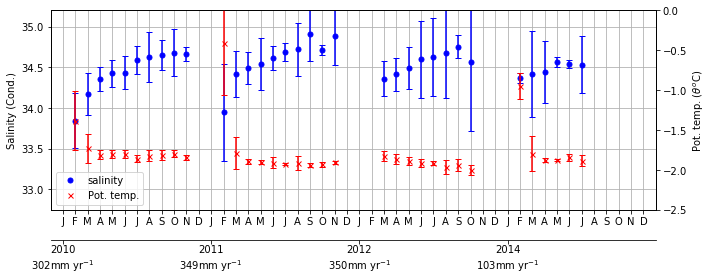

In [919]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Ross&~gline_le_75km, 
                                              years=[2010, 2011, 2012, 2014], markersize=5, save=True, 
                                                    savename="./Images/RossSurfSal_Xclude_GLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

15.832959347337471 1027.60510267 34.3992904351 1027.60510267 34.3992904351
15.832959347337471 1027.88187723 34.7471653801 1027.34209054 34.080248956


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


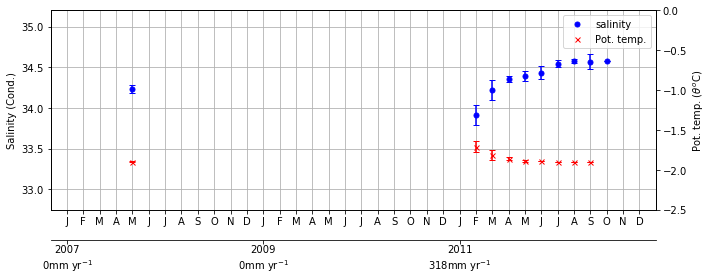

In [920]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Weddell&gline_le_75km&deep_mask, 
                                              years=[2007, 2009, 2011], markersize=5, save=True,
                                                    savename="./Images/WeddellSurfSalGLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

15.833800069667083 1027.9208058 34.7902139932 1027.34948834 34.0860049771
15.833800069667083 1027.85934599 34.7119270903 1027.47302062 34.2387093473
15.833800069667083 1027.81517301 34.6411561259 1027.42998189 34.1868858494


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


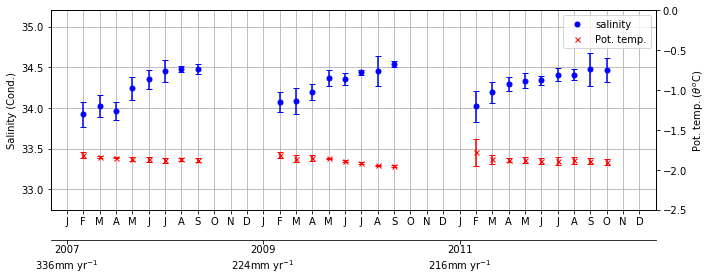

In [921]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Weddell&~gline_le_75km, 
                                              years=[2007, 2009, 2011], markersize=5, save=True,
                                                    savename="./Images/WeddellSurfSal_Xclude_GLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

11.818316476497795 1027.90722025 34.7857401515 1027.125028 33.8376394695
11.818316476497795 1027.92428394 34.8063011946 1027.0255137 33.7179832432
11.818316476497795 1027.93256807 34.8258455763 1027.30253446 34.0416441291
11.818316476497795 1027.48558382 34.2729941641 1026.84933534 33.5396429426


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


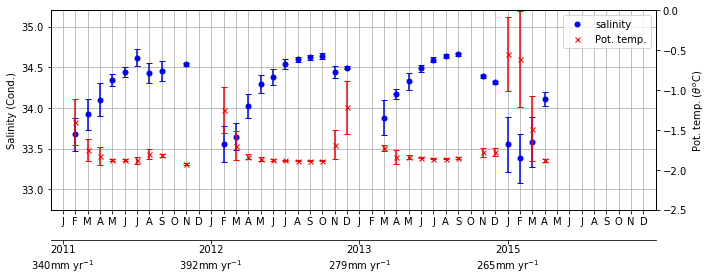

In [922]:
importlib.reload(pltSalYearAvg)
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Prydz&gline_le_75km, 
                                              years=[2011, 2012, 2013, 2015], markersize=5, wd=10, ht=4, save=True,
                                                    savename="./Images/PrydzSurfSalGLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

11.631175750624971 1027.6661642 34.4963009064 1027.07351919 33.782001842
11.631175750624971 1027.81118368 34.6664544302 1027.21143912 33.9725117085
11.631175750624971 1027.81339958 34.6799632678 1027.34238669 34.1003964292
11.631175750624971 1027.40181338 34.167949834 1026.46835046 33.0977497031


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


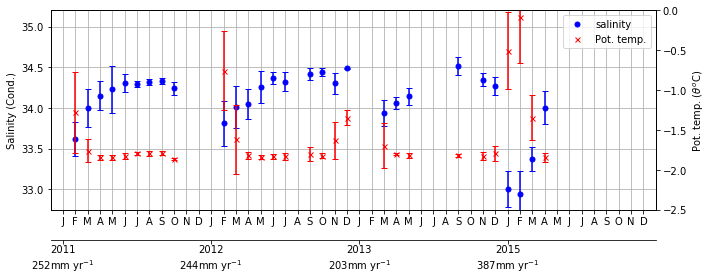

In [923]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Prydz&~gline_le_75km, 
                                              years=[2011, 2012, 2013, 2015], markersize=5, wd=10, ht=4, save=True,
                                                    savename="./Images/PrydzSurfSal_Xclude_GLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

In [345]:
ICE = xr.open_dataset("/media/data/Datasets/SeaIce/HadISST/HadISST_ice.nc")

In [368]:
def get_seaIceConc(ICE, timemin, timemax, latmin, latmax, lonmin, lonmax):
    timeStart = np.asscalar(np.argmin(np.abs(ICE['time'] - timemin)).values)
    timeEnd = np.asscalar(np.argmin(np.abs(ICE['time'] - timemax)).values)
    
    latStart = np.asscalar(np.argmin(np.abs(ICE['latitude'] - latmax)).values)
    latEnd = np.asscalar(np.argmin(np.abs(ICE['latitude'] - latmin)).values)
    
    lonStart = np.asscalar(np.argmin(np.abs(ICE['longitude'] - lonmin)).values)
    lonEnd = np.asscalar(np.argmin(np.abs(ICE['longitude'] - lonmax)).values)
    
    return timeStart, timeEnd, latStart, latEnd, lonStart, lonEnd

In [373]:
time = np.arange('2006-02', '2006-10', dtype='datetime64[M]')
latmin = -90
latmax = -60
lonmin = -70
lonmax = -11

timeS, timeE, latS, latE, lonS, lonE = get_seaIceConc(ICE, time[0], time[-1], latmin, latmax, lonmin, lonmax)

In [492]:
import cartopy.crs as ccrs

In [493]:
sic = ICE.sic

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


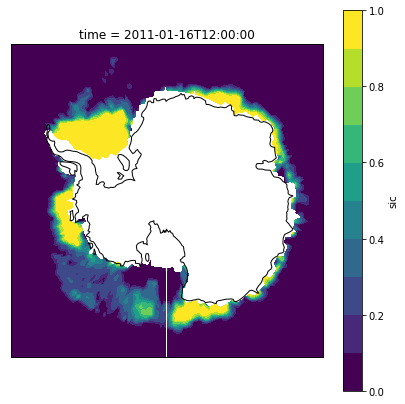

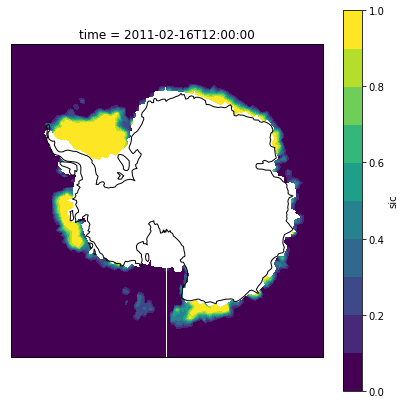

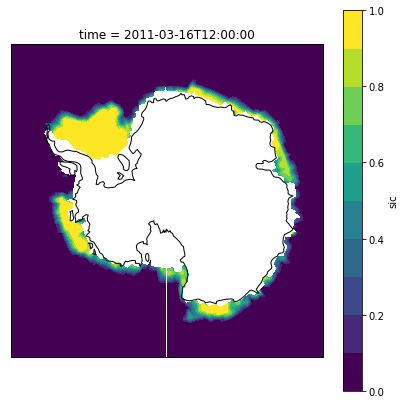

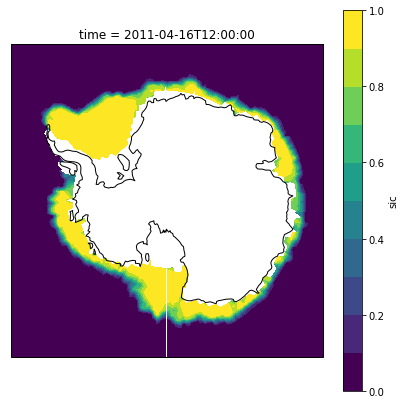

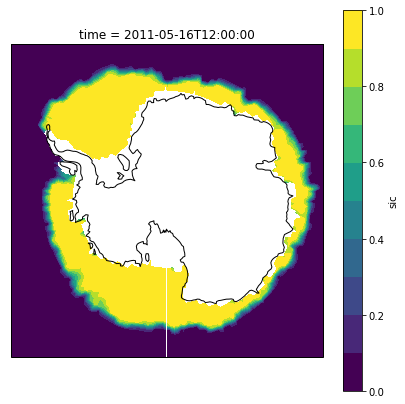

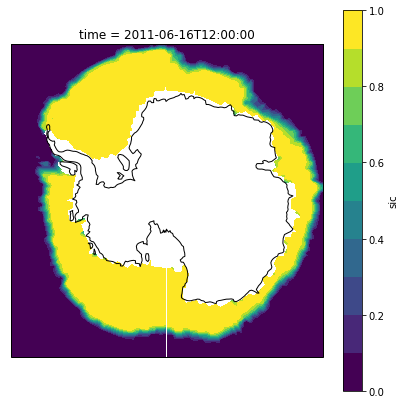

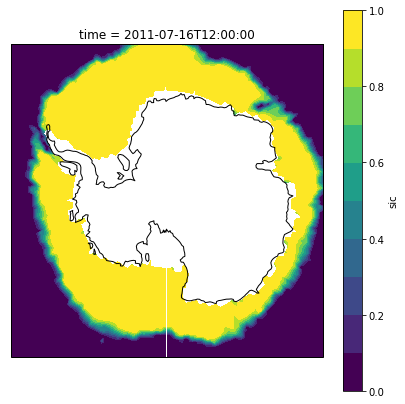

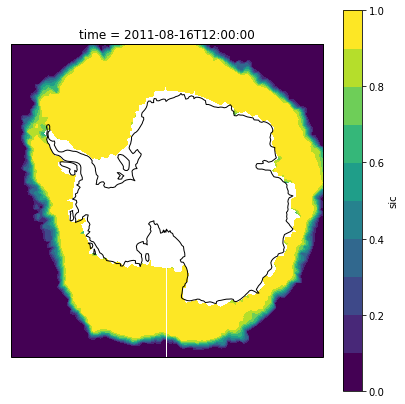

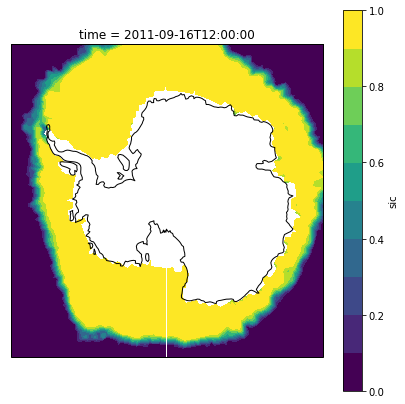

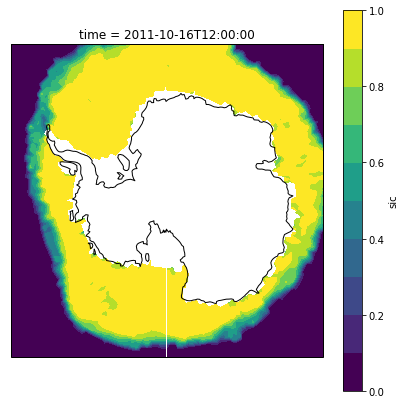

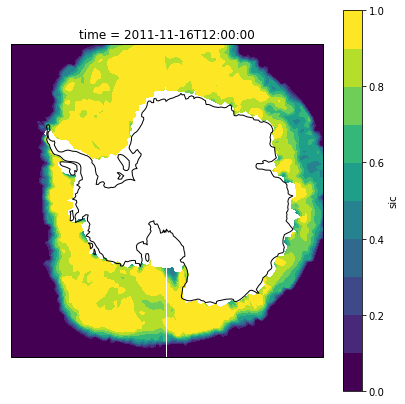

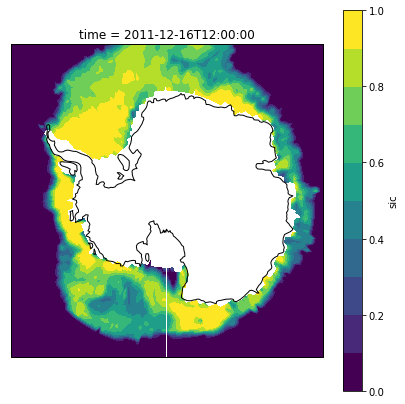

In [541]:
importlib.reload(topView)
time = np.arange('2011-02', '2012-02', dtype='datetime64[M]')
for i in range(len(time)):
    timeind = np.asscalar(np.argmin(np.abs(ICE['time'] - time[i])).values)
    topView.plotSeaIceConc(ICE, timeind, show=False, save=True, 
                           savename="./Images/SIC/2011_"+str(month_names[i])+".png")

In [542]:
for i in range(1,10,1):
    topView.plotDataDensity(dfmg.loc[Weddell & deep_mask & year_mask[7] & month_mask[i]], save=True, 
            savename="./Images/dataDensityWeddell2011Monthwise/dataDensityWeddell2011"+str(month_names[i])+".png", 
            wd=10, ht=10, nx=300, ny=300, region='Weddell', levels=[0,10,20,30,40,50])

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


<IPython.core.display.Javascript object>


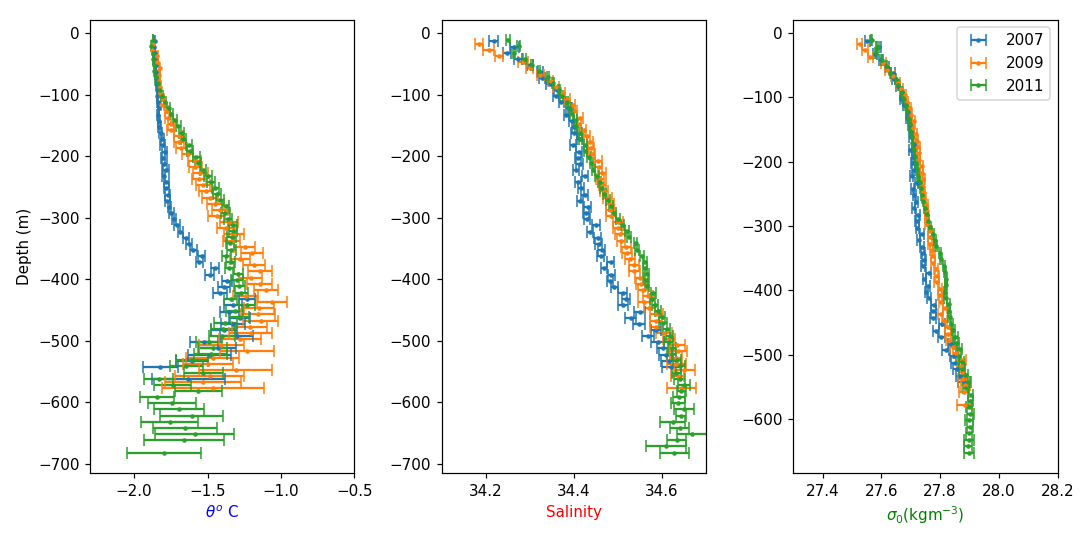

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


In [108]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Weddell & (~gline_le_100km), years=[2007, 2009, 2011], 
                                                    sigmin=27.3, 
                                                    sigmax=28.2, salmin=34.1, salmax=34.7, wd=10, min_n=25)

<IPython.core.display.Javascript object>


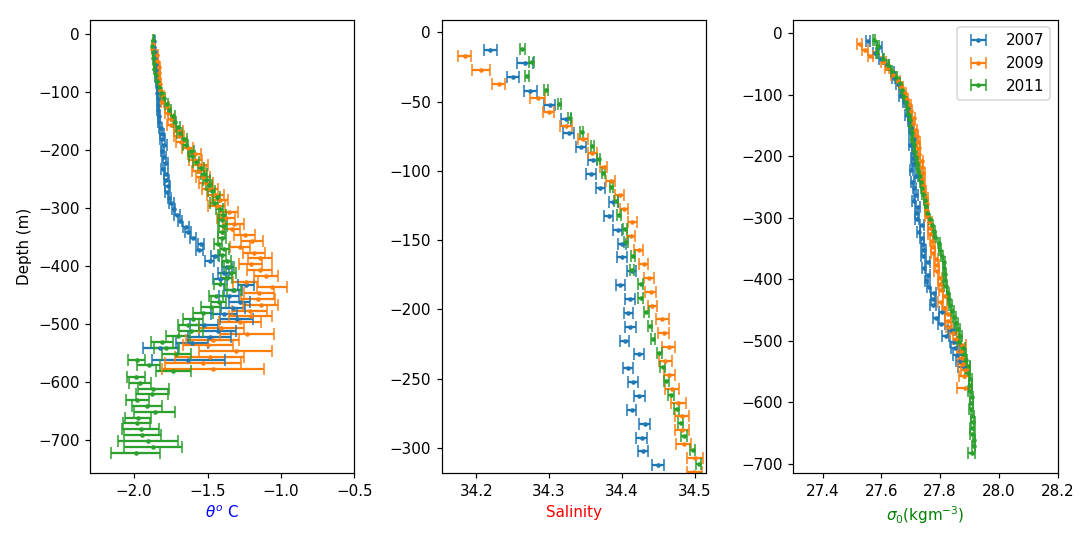

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


In [107]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Weddell, years=[2007, 2009, 2011], sigmin=27.3, 
                                                    sigmax=28.2, salmin=34.1, salmax=34.7, wd=10, min_n=25)

<IPython.core.display.Javascript object>


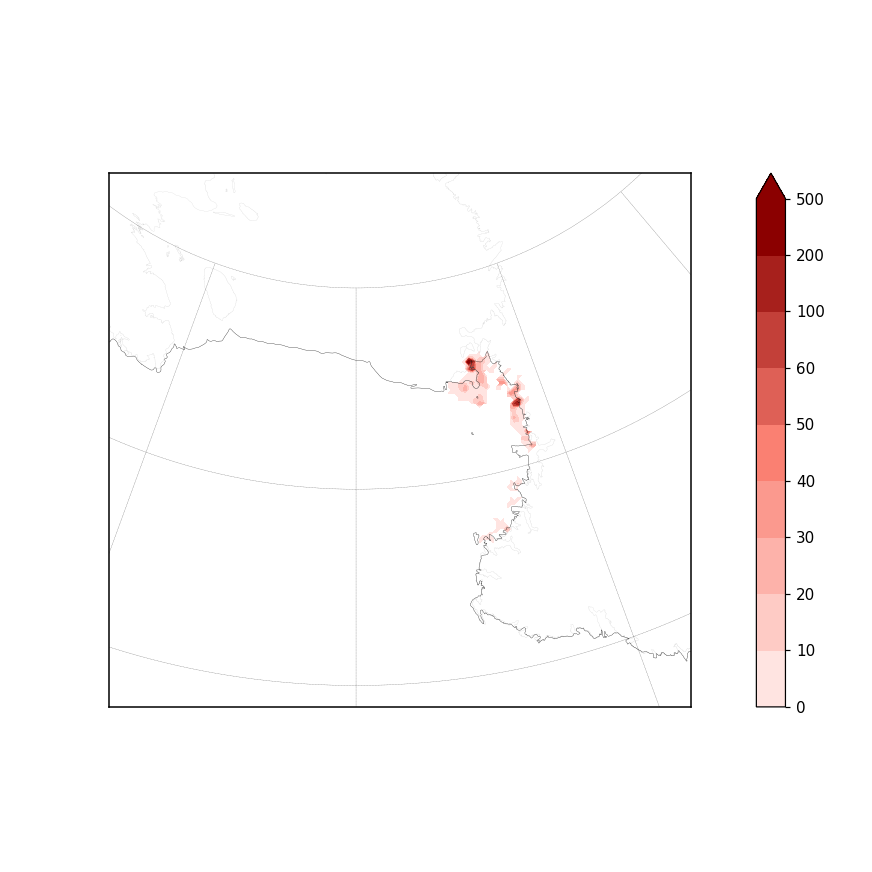

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [120]:
var = 'PSAL_ADJUSTED'
dfno = dfmg.loc[~dfmg.loc[:, var].isnull() & year_mask[7] & gline_le_50km]
levels = [0, 10, 20, 30, 40, 50, 60, 100, 200, 500] #, 90, 150, 250, 500, 1000, 2500]
topView.plotDataDensity(dfno, wd=8, ht=8, nx=820, ny=820, levels=levels, 
                        save=False, show=True)

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2
0 3


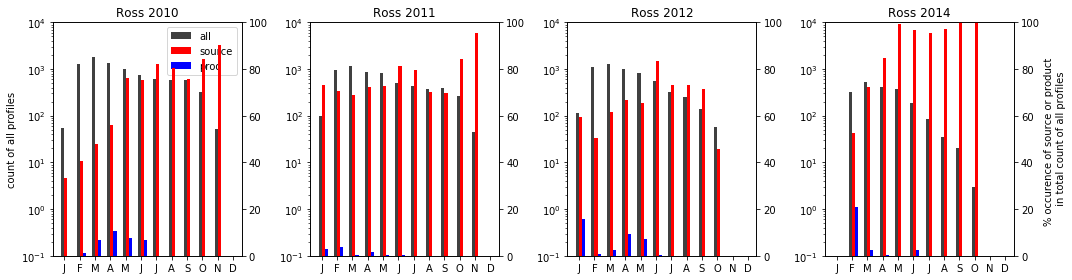

In [58]:
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[Ross&year_mask[6], Ross&year_mask[7], Ross&year_mask[8], Ross&year_mask[10]], 
                             row=1, col=4, titles=['Ross 2010','Ross 2011', 'Ross 2012', 'Ross 2014'], ht=4, wd=15)

In [67]:
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[Ross&year_mask[6], Ross&year_mask[7], Ross&year_mask[8], Ross&year_mask[10]], 
                             row=1, col=4, titles=['Ross 2010','Ross 2011', 'Ross 2012', 'Ross 2014'], ht=4, wd=15)

array([2007, 2008, 2009, 2010, 2011])

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2


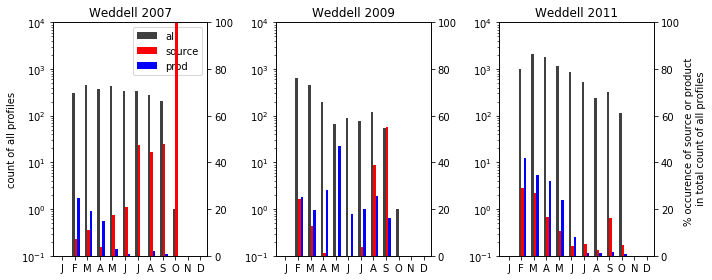

In [283]:
region = Weddell & ~gline_le_100km
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[region&year_mask[3],  region&year_mask[5], region&year_mask[7]],
                             row=1, col=3, titles=['Weddell 2007', 'Weddell 2009', 'Weddell 2011'], ht=4, wd=10)

In [559]:
years[2]

2006

In [568]:
dfmg.loc[dfmg.loc[region&year_mask[3]].groupby('PROFILE_NUMBER').tail(1).index, 'PLATFORM_NUMBER'].unique()

array(["b'00012048'", "b'00012054'", "b'00012060'", "b'00012192'"], dtype=object)

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2
1 0
1 1
1 2


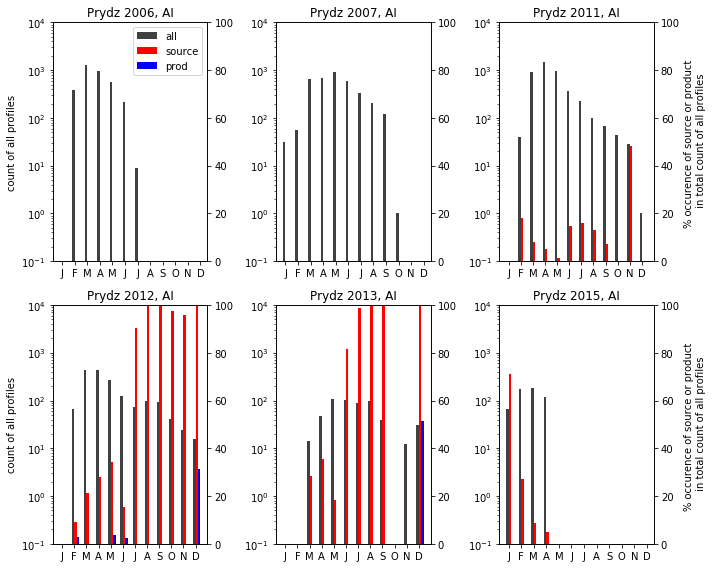

In [165]:
importlib.reload(monthCount)
region = Prydz & gline_le_75km
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[region&year_mask[2],  region&year_mask[3], region&year_mask[7], 
                                   region&year_mask[8], region&year_mask[9], region&year_mask[11]],
                             row=2, col=3, titles=['Prydz 2006, AI', 'Prydz 2007, AI', 'Prydz 2011, AI', 
                                                  'Prydz 2012, AI', 'Prydz 2013, AI', 'Prydz 2015, AI'], ht=8, wd=10)

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2
1 0
1 1
1 2


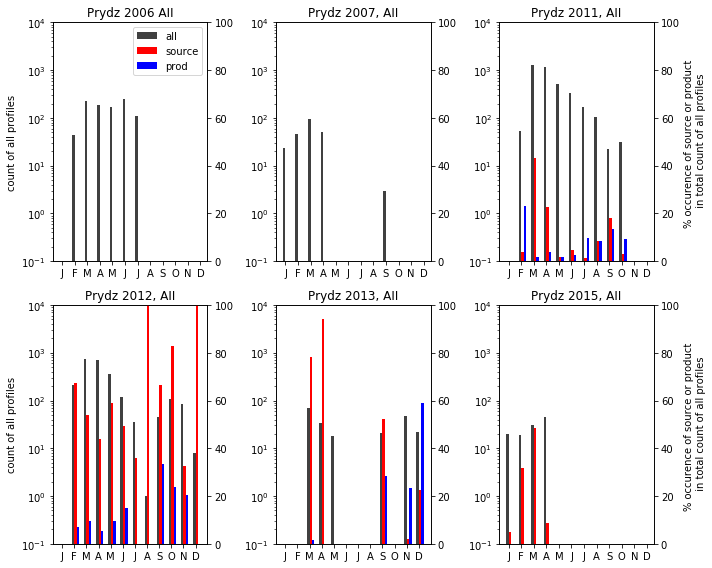

In [164]:
importlib.reload(monthCount)
region = Prydz & ~gline_le_75km
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[region&year_mask[2],  region&year_mask[3], region&year_mask[7], 
                                   region&year_mask[8], region&year_mask[9], region&year_mask[11]],
                             row=2, col=3, titles=['Prydz 2006 AII', 'Prydz 2007, AII', 'Prydz 2011, AII', 
                                                  'Prydz 2012, AII', 'Prydz 2013, AII', 'Prydz 2015, AII'], 
                             ht=8, wd=10)

## $\theta$ - S profiles - Prydz Bay

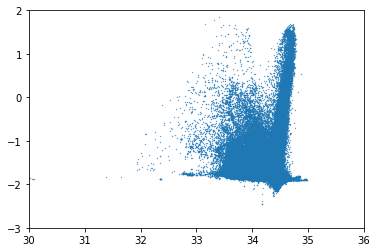

In [66]:
all_thetas = dfmg.loc[Prydz, 'CTEMP']
all_sals = dfmg.loc[Prydz, 'PSAL_ADJUSTED']
plt.scatter(all_sals, all_thetas, s=0.1)
plt.xlim(30, 36)
plt.ylim(-3, 2)
plt.show()

## $\theta$ - S profiles - Bellingshaussen Sea

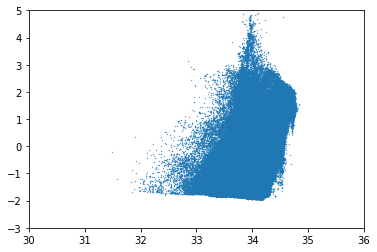

In [68]:
all_thetas = dfmg.loc[EBS, 'CTEMP']
all_sals = dfmg.loc[EBS, 'PSAL_ADJUSTED']
plt.scatter(all_sals, all_thetas, s=0.1)
plt.xlim(30, 36)
plt.ylim(-3, 5)
plt.show()

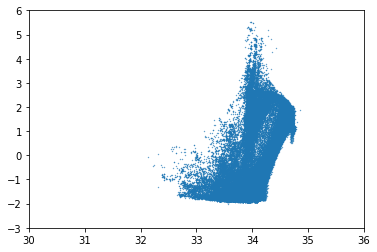

In [71]:
all_thetas = dfmg.loc[WBS, 'CTEMP']
all_sals = dfmg.loc[WBS, 'PSAL_ADJUSTED']
plt.scatter(all_sals, all_thetas, s=0.1)
plt.xlim(30, 36)
plt.ylim(-3, 6)
plt.show()

In [112]:
importlib.reload(plot_theta_sal)

<module 'plot_theta_sal' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_theta_sal.py'>

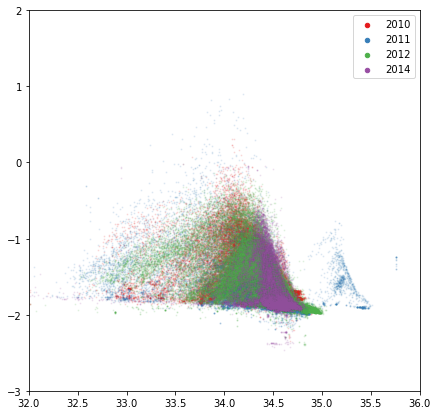

In [55]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2010, 2011, 2012, 2014], alpha=0.1)

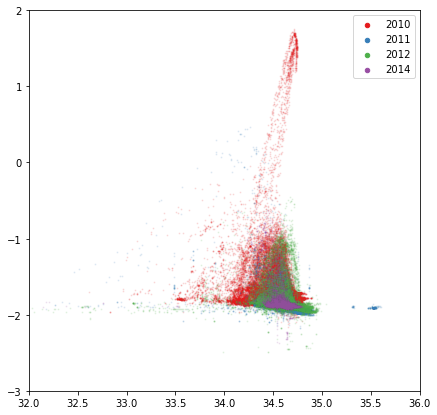

In [60]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2010, 2011, 2012, 2014], alpha=0.1)

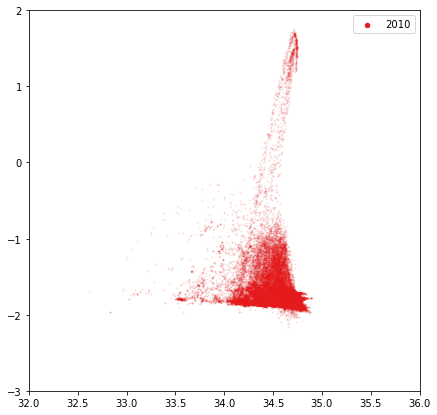

In [62]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2010], alpha=0.1)

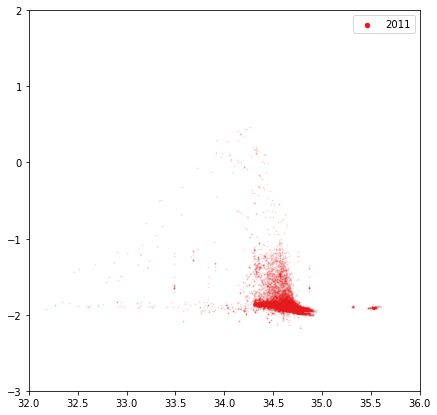

In [61]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2011], alpha=0.1)

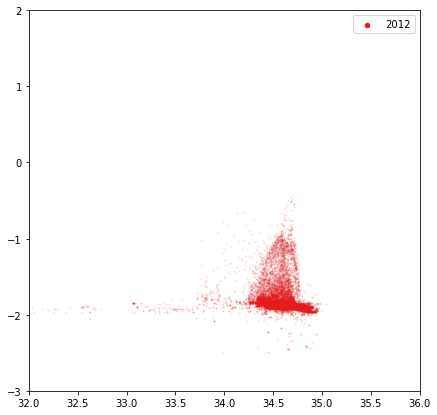

In [63]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2012], alpha=0.1)

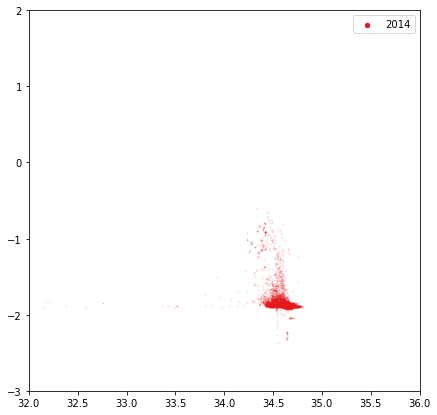

In [64]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2014], alpha=0.1)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


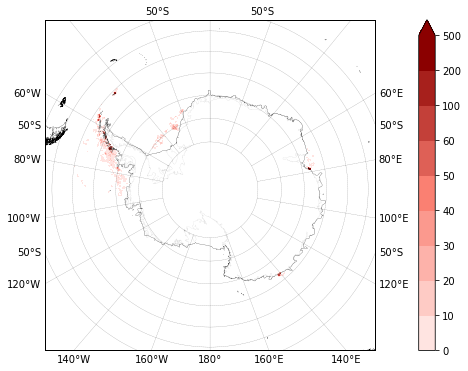

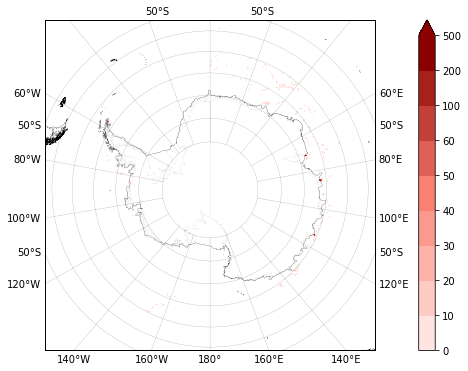

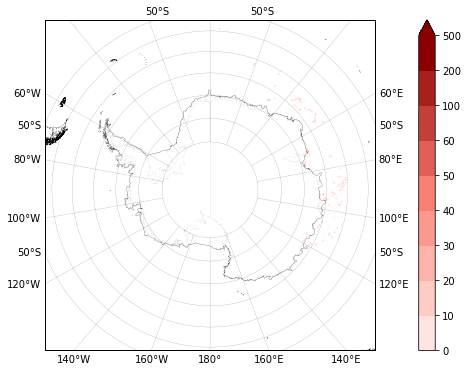

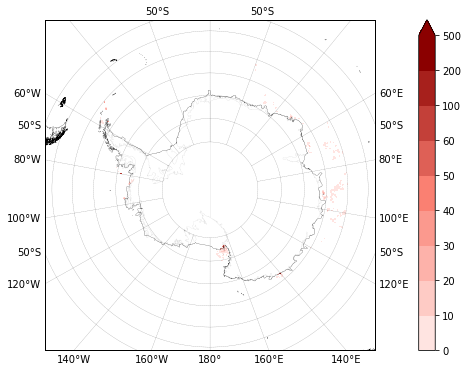

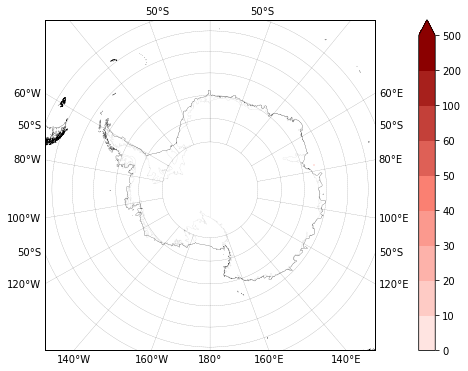

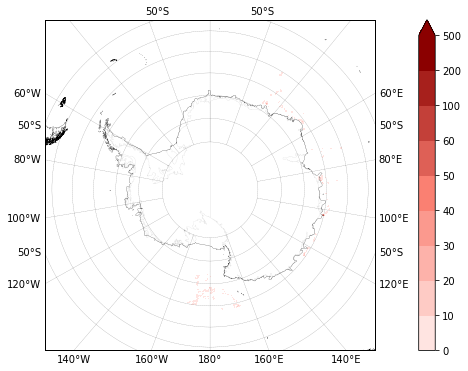

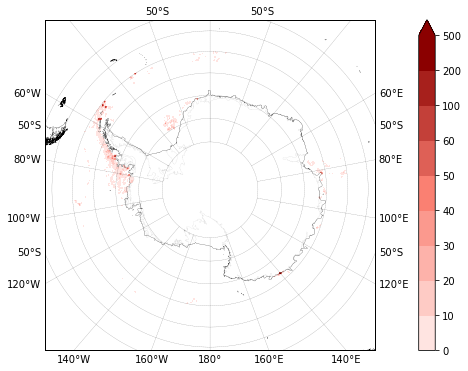

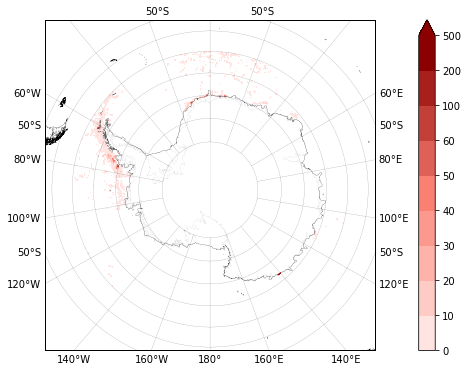

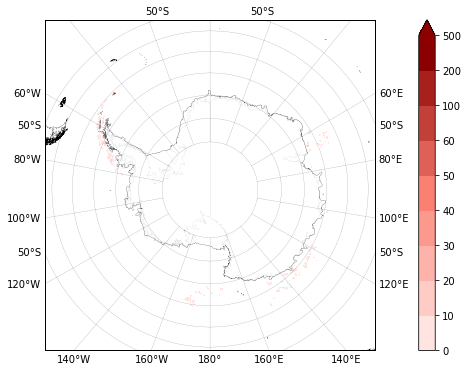

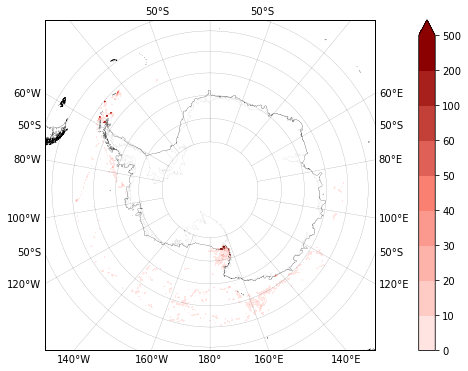

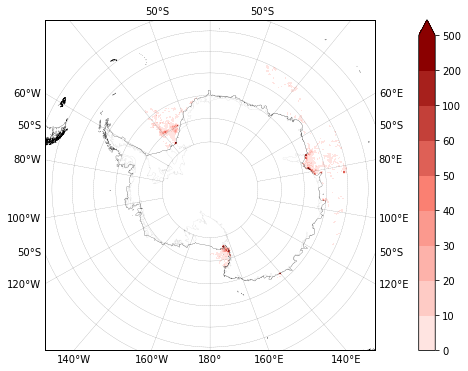

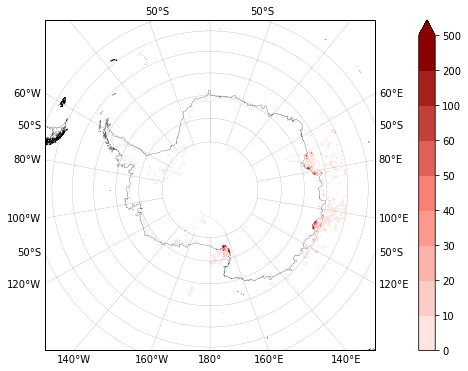

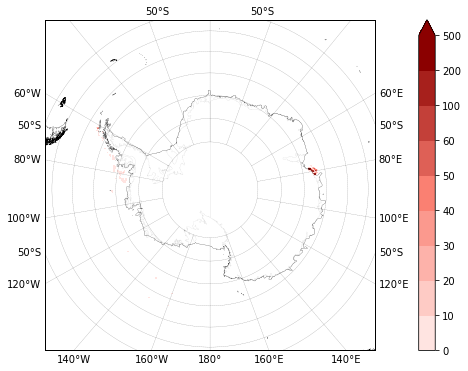

In [124]:
years = dfmg['JULD'].dt.year.unique()
for i in range(len(years)):
    year_mask = dfmg['JULD'].dt.year == years[i]
    topView.plotDataDensity(dfmg[year_mask], show=True, save=True, savename="DataDensity_"+str(years[i])+".png", 
                            levels= [0, 10, 20, 30, 40, 50, 60, 100, 200, 500])

In [700]:
dfmg[Ross].groupby('PROFILE_NUMBER').head(1).DEPTH.quantile(0.01)

-9.895327631355554

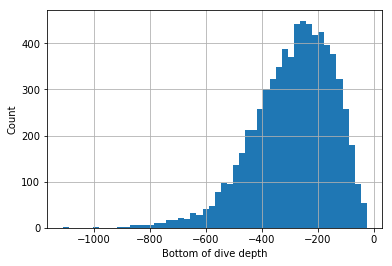

In [76]:
ax = dfmg[Ross&gline_le_75km&deep_mask].groupby('PROFILE_NUMBER').tail(1).DEPTH.hist(bins=50)
ax.set_xlabel("Bottom of dive depth")
ax.set_ylabel("Count")
plt.show()

In [850]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PROFILE_NUMBER', 'PSAL_ADJUSTED',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'DEPTH',
       'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP', 'DENSITY_GRADIENT',
       'ECHODEPTH', 'mab', 'deep_flag', 'DIST_GLINE', 'SA'],
      dtype='object')

In [13]:
dfmg.loc[Ross&gline_le_75km, 'LATITUDE'].describe()

count    301425.000000
mean        -77.183722
std           0.755025
min         -78.259400
25%         -77.694800
50%         -77.366600
75%         -76.907300
max         -72.868500
Name: LATITUDE, dtype: float64

In [12]:
dfmg.loc[Ross&gline_le_75km, 'LONGITUDE'].describe()

count    301425.000000
mean        166.285661
std           2.071870
min         161.051700
25%         165.110800
50%         166.616200
75%         167.203500
max         172.474600
Name: LONGITUDE, dtype: float64

In [425]:
import plot_freshwater_vs_years as pltfh

In [214]:
salrange = list(np.arange(33.5, 35.05, 0.01))
salrange_disc = list(np.arange(33.5, 35.05, 0.1))
thetarange = list(np.arange(-3, 1, 0.01))
thetarange_disc = list(np.arange(-3, 1, 0.1))
RossYears = [2010, 2011, 2012, 2014]
WeddellYears= [2007, 2009, 2011]
PrydzYears = [2011, 2012, 2013, 2015]

In [518]:
import plot_Profiles_vs_time as profile2dTime
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py'>

2010


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month


2011
2012
2014


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:52: RuntimeWarning: Mean of empty slice
  P_mon_mean[i] = np.nanmean(P[i]) * float(monthrange(year, i+1)[1])
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:53: RuntimeWarning: Mean of empty slice
  P_mon_mean_err[i] = np.nanmean(P_err[i]) * float(monthrange(year, i+1)[1])
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:170: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0765915902754 2.14282705854


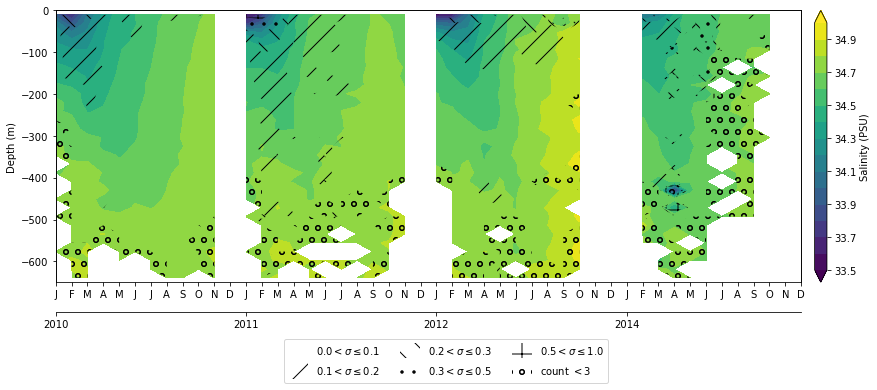

In [519]:
Rossle75_f_h, depth_bins = profile2dTime.plot_sal_contours_with_time(dfmg[Ross&gline_le_75km], 
                                          years=[2010, 2011, 2012, 2014], depth_max=-650, zbin=20, 
                                          levs=salrange_disc, save=True, 
                                         savename="./Images/seasonal/RossSalGLle75km_disc.png", type=1, wd=4*4)

In [409]:
Rossle75_f_h[0][0][0, ::-1][0:6].sum()

2441.2378426173536

In [443]:
np.nansum(Rossle75_f_h[0][1][3, ::-1][0:6])

149.17349591219042

In [454]:
Rossle75_f_h[0][0][3, ::-1][0:6].sum()

1331.1561016117271

In [501]:
importlib.reload(pltfh)

<module 'plot_freshwater_vs_years' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_freshwater_vs_years.py'>

2010 2441.23784262 -2.84759559321 104.808246972
2011 2260.13394981 -160.724284618 113.1251483
2012 2623.33125914 -76.5927431947 124.108281589
2014 1331.15610161 100.074606434 113.408790219


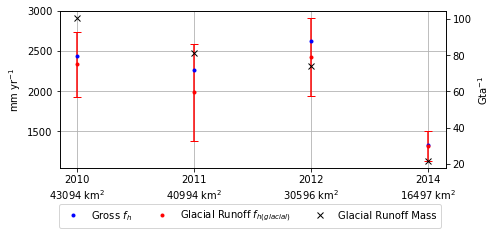

[ 407.15445976  605.82738594  488.22176139  183.47767314]


array([ 2333.58200005,  1986.28451689,  2422.63023436,  1317.82191783])

In [502]:
pltfh.print_yearly_fh(Rossle75_f_h, [2010, 2011, 2012, 2014], area_Ross_le75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Ross_le75.png', wd=7)

In [186]:
print_yearly_fh(Rossle75_f_h, [2010, 2011, 2012, 2014])

2010 2339.27719124
2011 2307.73308612
2012 2575.81572075
2014 1117.67270496


In [183]:
Rossle75_f_h[0, ::-1][0:6].sum() * 1e-3 * area_Ross_le75 * 1030.0 * 1e-12

0.00014926376687407006

In [326]:
m = topView.createMapProjections(-90, 0, region="Whole")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


In [329]:
area_Ross_le75 = topView.find_area(dfmg[Ross&gline_le_75km], m, years=Ross_years)

In [327]:
Ross_years = [2010, 2011, 2012, 2014]
area_Ross_Xle75 = topView.find_area(dfmg[Ross & ~gline_le_75km], m, years=Ross_years)

In [356]:
Weddell_years = [2007, 2009, 2011]
area_Weddell_le75 = topView.find_area(dfmg[Weddell & gline_le_75km], m, years=Weddell_years)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_topView_contourf.py:396: UserWarning: Warning: converting a masked element to nan.
  area[j] = cell_size_x * cell_size_y * number_of_cells


In [357]:
area_Weddell_Xle75 = topView.find_area(dfmg[Weddell & ~gline_le_75km], m, years=Weddell_years)

In [330]:
Prydz_years = [2011, 2012, 2013, 2015]
area_Prydz_le75 = topView.find_area(dfmg[Prydz & gline_le_75km], m, years=Prydz_years)

In [331]:
area_Prydz_Xle75 = topView.find_area(dfmg[Prydz & ~gline_le_75km], m, years=Prydz_years)

In [131]:
print(area_Ross_le75, area_Ross_Xle75, area_Weddell_le75, area_Weddell_Xle75 , area_Prydz_le75, area_Prydz_Xle75)

59292.64020517021 140882.51273 10498.6968323 236770.610465 54993.1738834 147981.631541


2010


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:52: RuntimeWarning: Mean of empty slice
  P_mon_mean[i] = np.nanmean(P[i]) * float(monthrange(year, i+1)[1])
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:53: RuntimeWarning: Mean of empty slice
  P_mon_mean_err[i] = np.nanmean(P_err[i]) * float(monthrange(year, i+1)[1])


2011
2012
2014


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:170: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0844986459539 0.628937230564


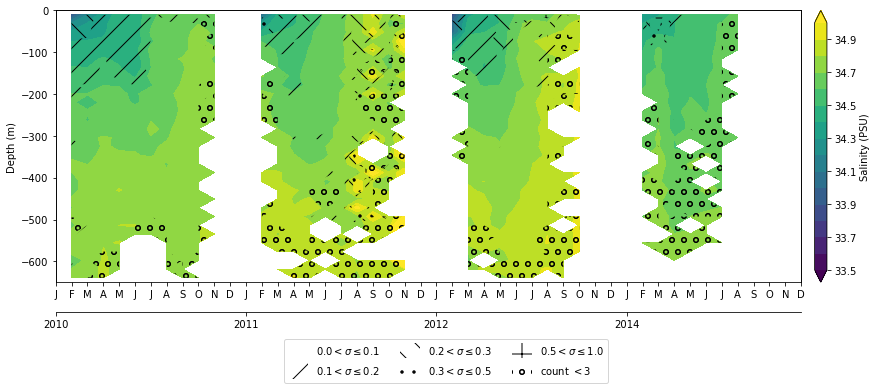

In [520]:
RossXle75_f_h, dbins = profile2dTime.plot_sal_contours_with_time(dfmg[Ross&~gline_le_75km], 
                                          years=[2010, 2011, 2012, 2014], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True, 
                                         savename="./Images/seasonal/RossSal_XGLle75km_disc.png", wd=4*4)

2010 1602.15954371 0.0 152.491532342
2011 1971.23570785 -113.813588108 114.222044473
2012 2512.58396422 0.0 146.031961826
2014 778.848077425 -125.989656924 124.736923062


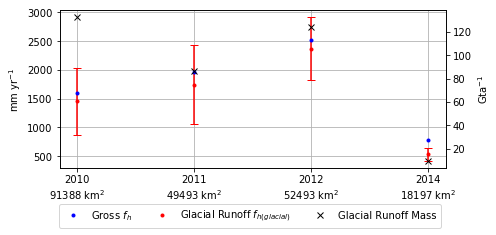

[ 576.79827895  687.79130334  549.39614032  109.2308482 ]


array([ 1449.66801137,  1743.20007527,  2366.55200239,   528.12149744])

In [503]:
pltfh.print_yearly_fh(RossXle75_f_h, [2010, 2011, 2012, 2014], area_Ross_Xle75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Ross_X_le75.png', wd=7)

In [42]:
dfmg[Weddell&gline_le_75km].LATITUDE.describe()

count    16123.000000
mean       -77.528460
std          0.749921
min        -78.291100
25%        -77.856900
50%        -77.844500
75%        -77.795300
max        -72.943900
Name: LATITUDE, dtype: float64

In [43]:
dfmg[Weddell&gline_le_75km].LONGITUDE.describe()

count    16123.000000
mean       -35.543118
std          3.128105
min        -46.238500
25%        -36.437900
50%        -36.298800
75%        -36.146300
max        -20.140800
Name: LONGITUDE, dtype: float64

In [252]:
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py'>

2007


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:52: RuntimeWarning: Mean of empty slice
  P_mon_mean[i] = np.nanmean(P[i]) * float(monthrange(year, i+1)[1])
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:53: RuntimeWarning: Mean of empty slice
  P_mon_mean_err[i] = np.nanmean(P_err[i]) * float(monthrange(year, i+1)[1])


2009
2011


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:170: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0377830089712 0.116036586175


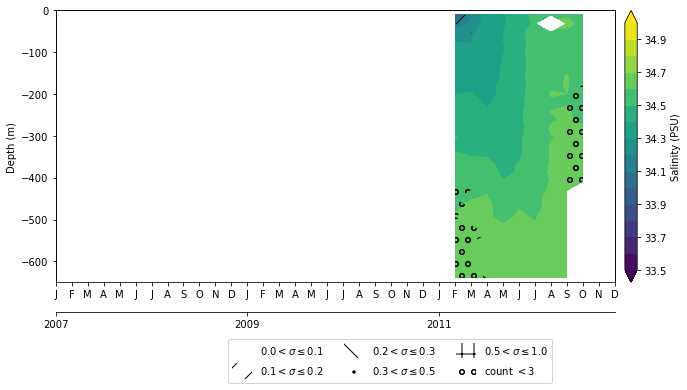

In [521]:
Weddellle75_fh, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Weddell&gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True,
                                         savename="./Images/seasonal/WeddellSalGLle75km_disc.png", wd=4*3)

In [482]:
area_Weddell_le75

array([ 1099.86347767,     0.        ,  9298.84576573])

2007 0.0 0.0 nan
2009 0.0 0.0 0.0
2011 1455.02778582 -116.774282514 77.5036748327


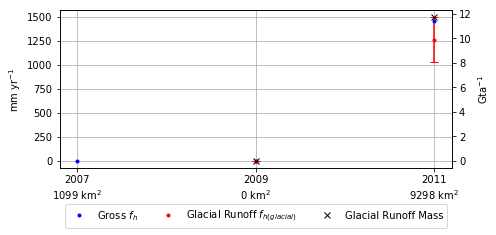

[          nan    0.          232.04363887]


array([           nan,     0.        ,  1260.74982847])

In [522]:
pltfh.print_yearly_fh(Weddellle75_fh, [2007, 2009, 2011], area_Weddell_le75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Weddell_le75.png', wd=7)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:232: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0619736955372 0.360783310816


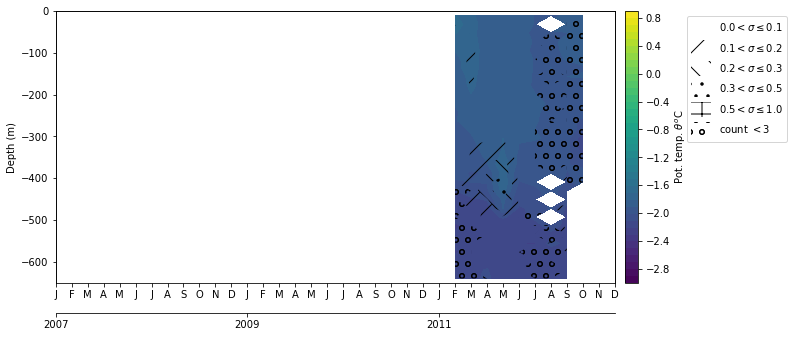

In [44]:
profile2dTime.plot_CT_contours_with_time(dfmg[Weddell&gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=thetarange_disc, save=True,
                                         savename="./Images/seasonal/WeddellCTGLle75km_disc.png", wd=4*3)

2007


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month


2009
2011


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:170: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0747756180677 0.355029407441


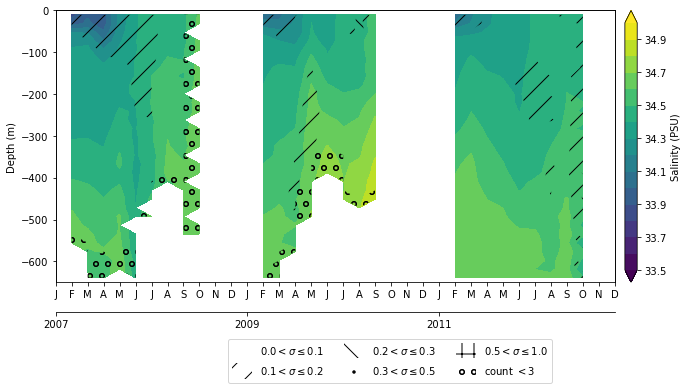

In [523]:
WeddellX75_fh, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Weddell&~gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True,
                                         savename="./Images/seasonal/WeddellSal_XGLle75km_disc.png", wd= 4*3)

In [367]:
area_Weddell_Xle75

array([  57192.90083871,   46694.20400643,  184177.13871488])

2007 1947.34396683 -234.484280123 97.5701056284
2009 1188.95721483 -199.147410772 112.064779735
2011 879.845232167 -95.647955378 98.6268310142


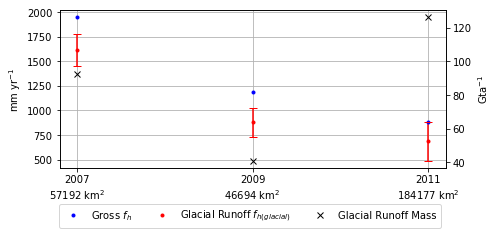

[ 165.76154235  151.46115997  196.24756123]


array([ 1615.28958107,   877.74502432,   685.57044577])

In [524]:
pltfh.print_yearly_fh(WeddellX75_fh, [2007, 2009, 2011], area_Weddell_Xle75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Weddell_X_le75.png', wd=7)

In [488]:
100 * 1e9 * 1e3 * 1e-12

100.0

In [50]:
dfmg.loc[Ross, 'LONGITUDE'].min()

-179.9716

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:262: RuntimeWarning: invalid value encountered in less
  #legend([plot1], "title", prop=fontP)


0.354475588333 1.55549552656


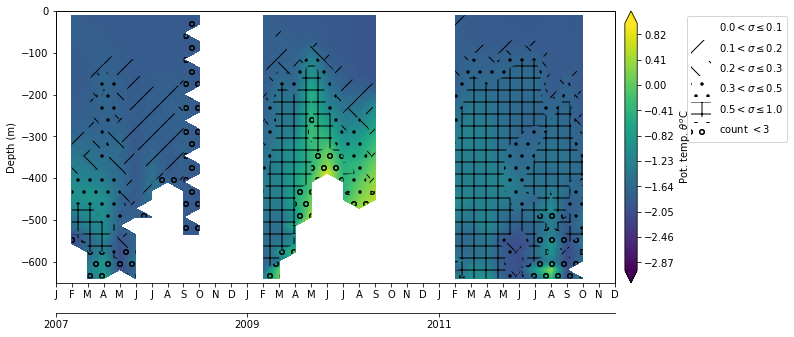

In [168]:
profile2dTime.plot_CT_contours_with_time(dfmg[Weddell&~gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=list(np.arange(-3, 1.01, 0.01)), save=True,
                                         savename="./Images/seasonal/WeddellCT_XGLle75km.png", wd= 4*3)

2011


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month


2012
2013
2015


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:165: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0646220133027 0.326079455653


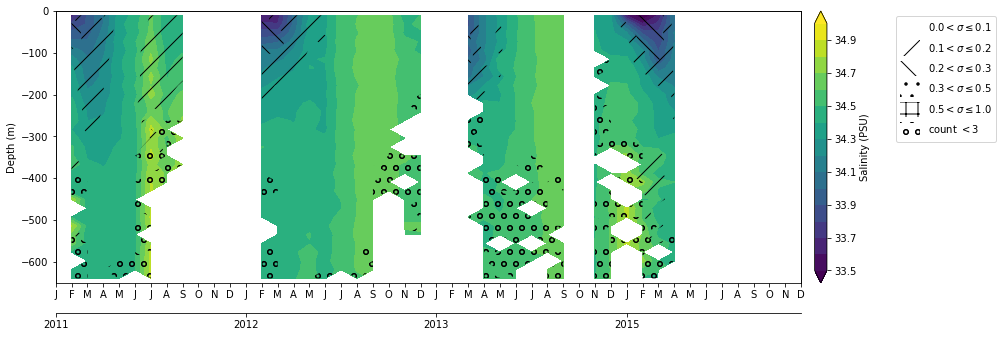

In [280]:
Prydzle75km_fh, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Prydz&gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True,
                                         savename="./Images/seasonal/PrydzSalGLle75km_disc.png", wd=4*4)

2011 2766.97396006 -183.242777436 80.0287340997
2012 2877.41942936 -244.371288103 83.6957626105
2013 2743.65085882 -319.882642371 117.366263991
2015 1937.60571273 -228.944082965 156.279194969


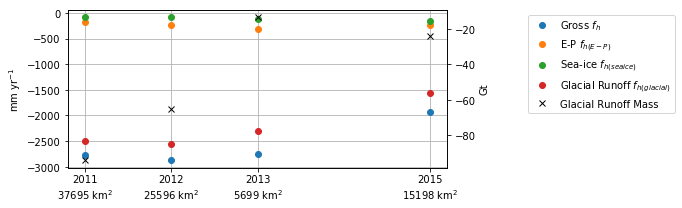

array([-2503.70244853, -2549.35237864, -2306.40195246, -1552.38243479])

In [369]:
print_yearly_fh(Prydzle75km_fh, [2011, 2012, 2013, 2015], area_Prydz_le75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Prydz_le75.png', wd=7)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:262: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0856536790666 0.595948069774


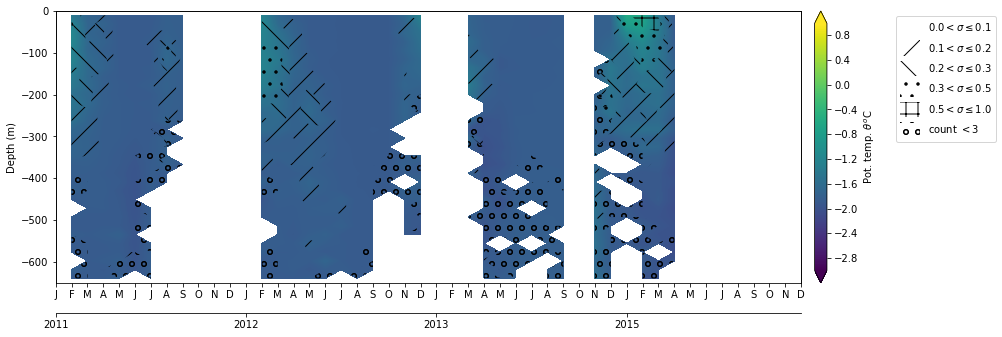

In [180]:
profile2dTime.plot_CT_contours_with_time(dfmg[Prydz&gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=thetarange, save=True,
                                         savename="./Images/seasonal/PrydzCTGLle75km.png", wd=4*4)

In [242]:
len(np.arange(-3, 1.01, 0.01))

401

2011


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month


2012
2013
2015


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:165: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0736226848042 0.424216458011


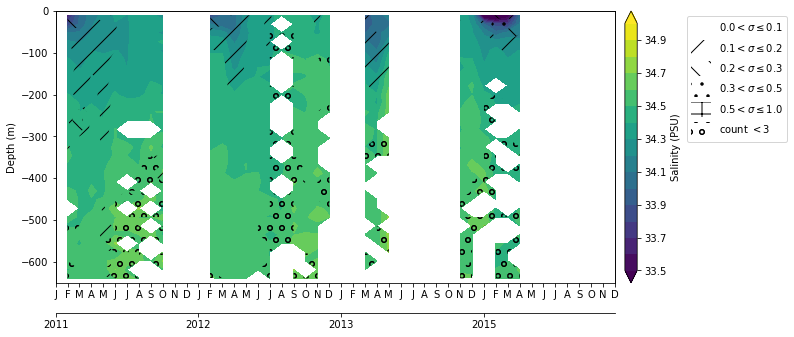

In [282]:
Prydz_X75_fh, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Prydz&~gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True,
                                         savename="./Images/seasonal/PrydzSal_XGLle75km_disc.png")

2011 1210.34846978 -166.785710878 88.0861593596
2012 1505.68103517 -244.488600024 85.1359541918
2013 2022.00924141 -291.791995928 143.240987586
2015 1015.64181169 -234.009795101 97.4009103964


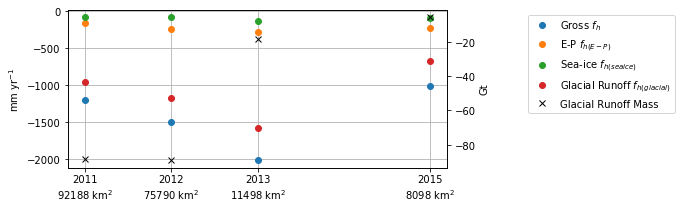

array([ -955.47659954, -1176.05648096, -1586.9762579 ,  -684.23110619])

In [370]:
print_yearly_fh(Prydz_X75_fh, [2011, 2012, 2013, 2015], area_Prydz_Xle75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Prydz_X_le75.png', wd=7)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:262: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.547563899799 1.63242107255


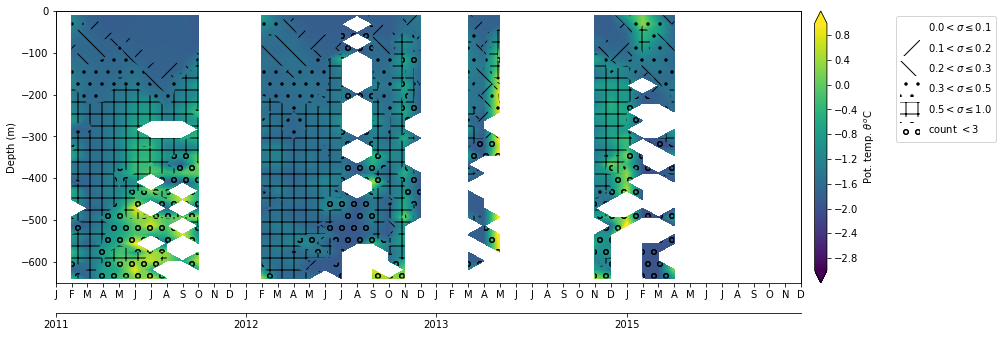

In [181]:
profile2dTime.plot_CT_contours_with_time(dfmg[Prydz&~gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=thetarange, save=True,
                                         savename="./Images/seasonal/PrydzCT_XGLle75km_disc.png", wd=4*4)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.530508036241


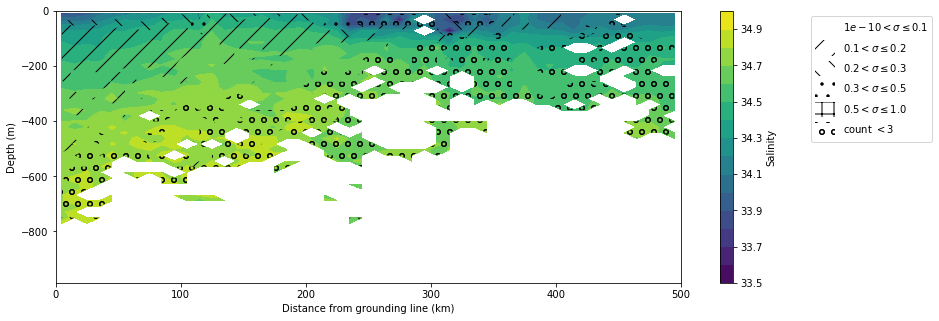

In [182]:
mask = Ross & sel_months(dfmg, [1,2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JFM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange_disc)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.530508036241


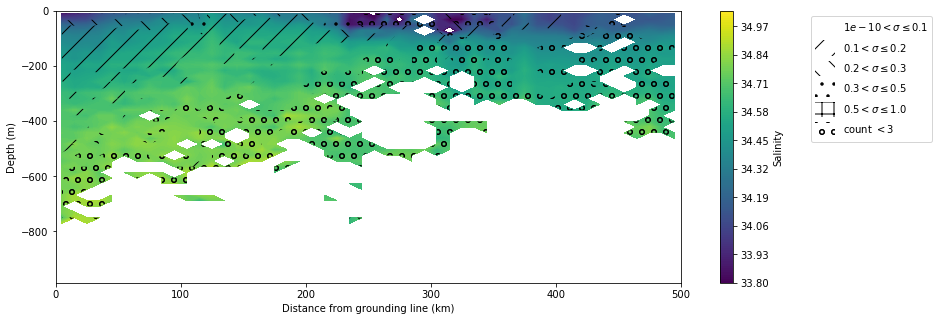

In [325]:
mask = Ross & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=list(np.arange(33.8, 35.05, 0.01)))

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


4.34670318691


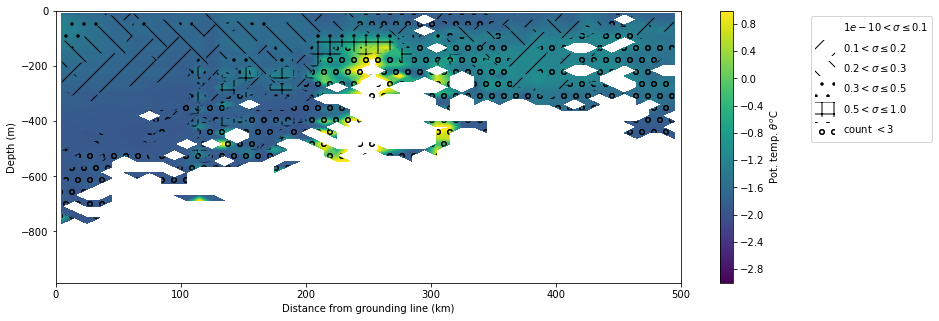

In [326]:
mask = Ross & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Ross_CTEMP_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-3, varmax=1, levs=thetarange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.614534421647


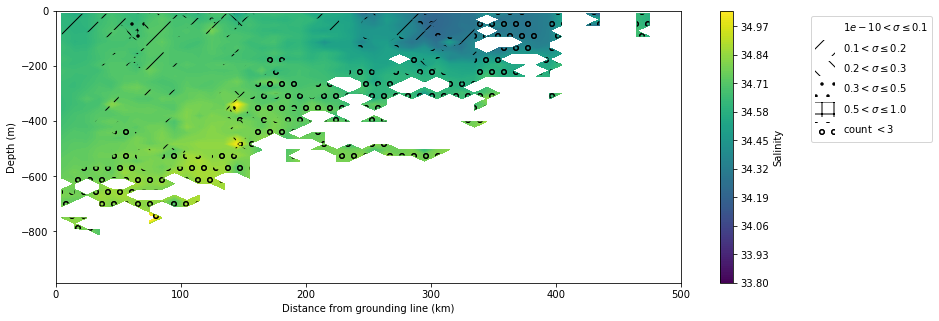

In [327]:
mask = Ross & sel_months(dfmg, [6,7,8])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JJA.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.835200327413


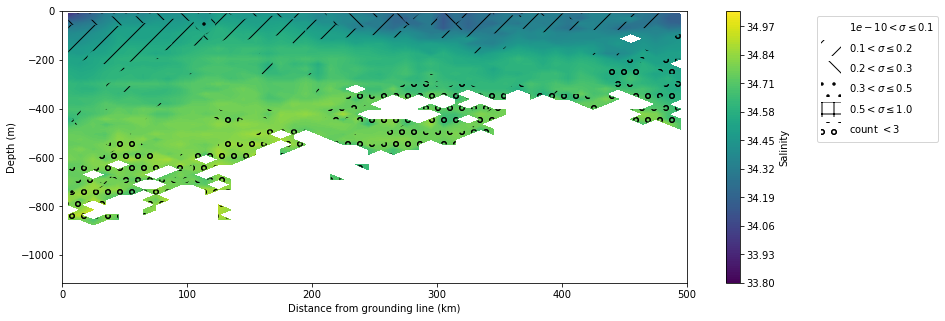

In [328]:
mask = Ross & sel_months(dfmg, [1,2,3,4,5])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JFMAM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.641571789698


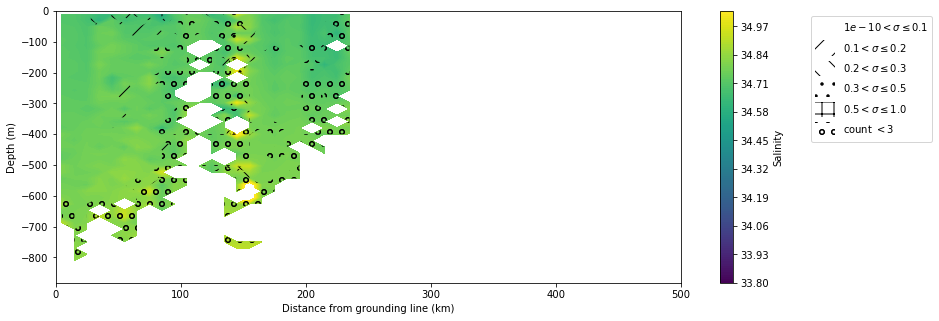

In [329]:
mask = Ross & sel_months(dfmg, [9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_SON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.208345547077


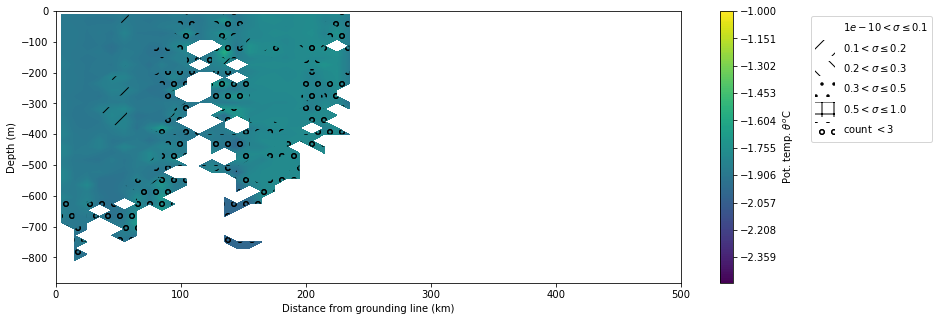

In [331]:
mask = Ross & sel_months(dfmg, [9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Ross_CTEMP_SON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-2.5, varmax=-1, nlevs=150)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.614534421647


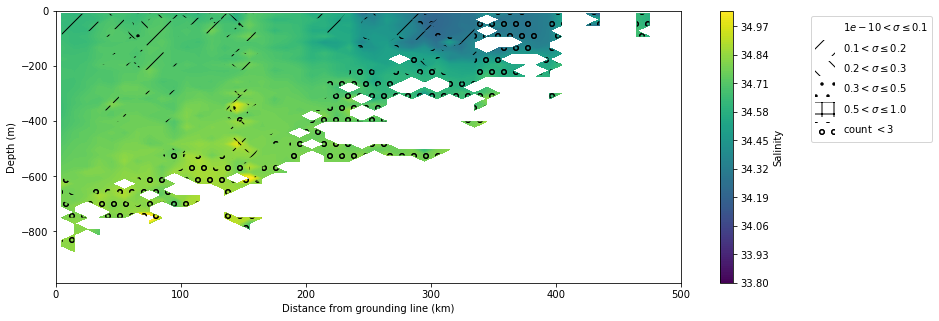

In [332]:
mask = Ross & sel_months(dfmg, [6,7,8,9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JJASON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.235334717021


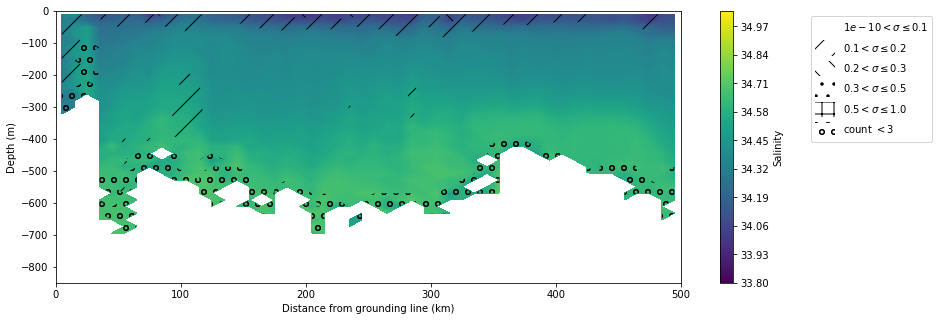

In [333]:
mask = Weddell & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Weddell_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, nlevs=9, levs=salrange)

In [123]:
np.linspace(-3, 1, 9)

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


1.50399063187


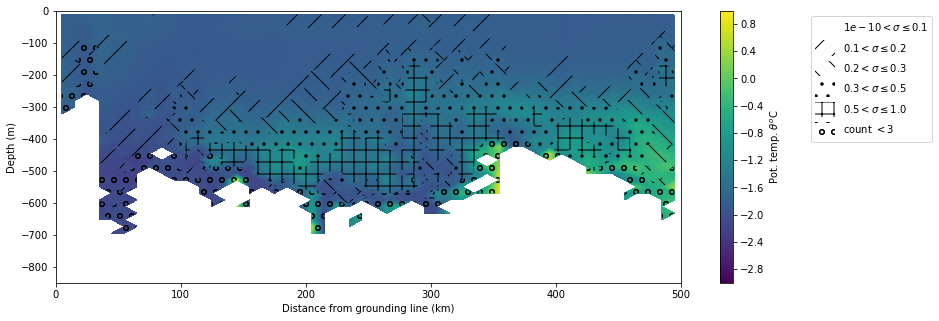

In [334]:
mask = Weddell & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Weddell_CTEMP_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-3, varmax=1, levs=thetarange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.515398808624


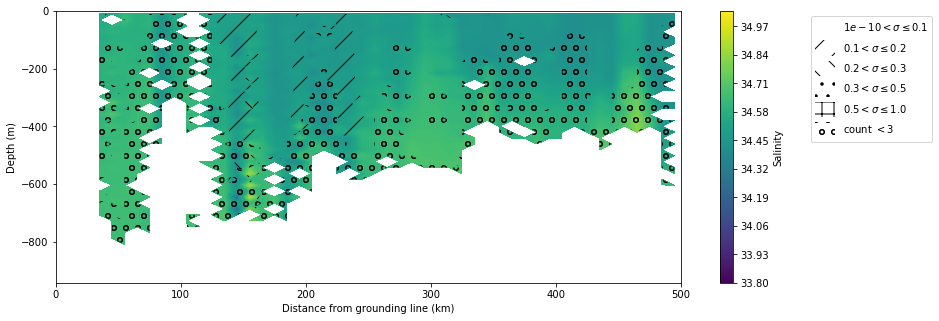

In [335]:
mask = Weddell & sel_months(dfmg, [9,10])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Weddell_SO.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


1.35045721024


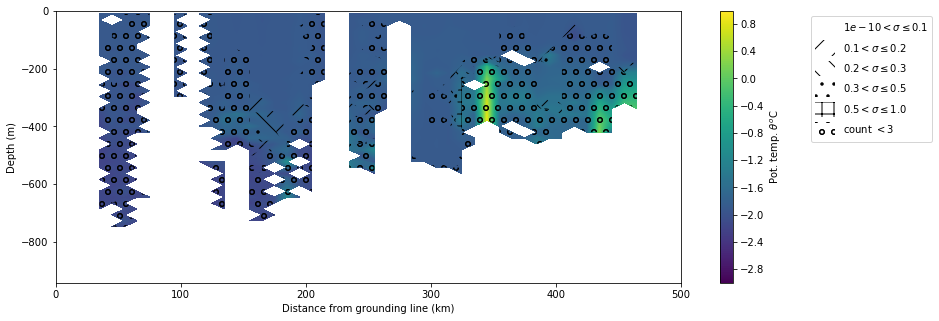

In [336]:
mask = Weddell & sel_months(dfmg, [9,10])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Weddell_CTEMP_SO.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-2.5, varmax=1, levs=thetarange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.864809577408


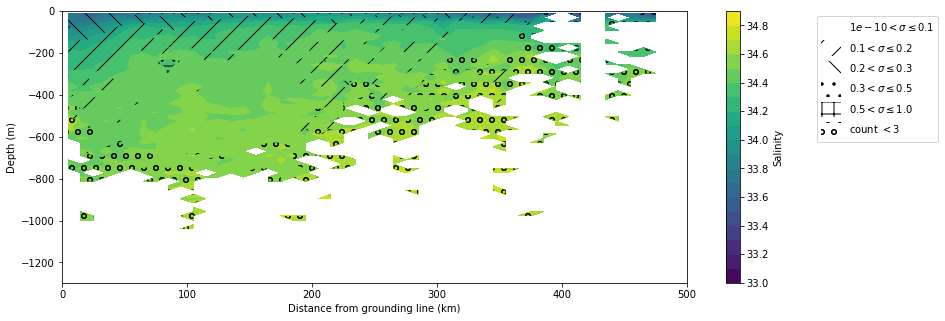

In [338]:
mask = Prydz & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Prydz_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=list(np.arange(33,35,.1)))